 # Deep learning meets missing data: Doing it MIWAE on MAR MNIST

 In this notebook, we'll learn a deep generative model on the MAR‐masked MNIST dataset and impute its missing pixels.

 # Installing and loading useful stuff

In [1]:
!pip3 install --user --upgrade scikit-learn

import torch
import torchvision
import torch.nn as nn
import numpy as np
import scipy.stats
import pandas as pd
import matplotlib.pyplot as plt
import torch.distributions as td
from torch import optim
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.linear_model import BayesianRidge
from sklearn.impute import IterativeImputer, SimpleImputer

from torchvision import transforms



 # Loading MNIST and applying MAR

In [2]:
from sklearn.model_selection import train_test_split



transform = torchvision.transforms.Compose([transforms.ToTensor(), transforms.Lambda(lambda x: x.view(-1))])
mnist = torchvision.datasets.MNIST(root='.', train=True, download=True, transform=transform)
data = mnist.data.float().view(-1, 784).numpy() / 255.0 + np.random.normal(0, 1, mnist.data.float().view(-1, 784).numpy().shape) * 0.1

data, _ = train_test_split(
    data, train_size=0.2, random_state=42, shuffle=True
)

bias, unbias = train_test_split(data, test_size=0.2, random_state=42)
print(f"Bias data shape: {bias.shape}")
print(f"Unbias data shape: {unbias.shape}")


Bias data shape: (9600, 784)
Unbias data shape: (2400, 784)


In [3]:
def create_mar_mask(data):
    masks = np.zeros((data.shape[0], data.shape[1]))
    for i, example in enumerate(data):
        h = (1. / (784. / 2.)) * np.sum(example[392:]) + 0.3
        pi = np.random.binomial(2, h)
        _mask = np.ones(example.shape[0])
        if pi == 0:
            _mask[196:392] = 0
        elif pi == 1:
            _mask[:392] = 0
        elif pi == 2:
            _mask[:196] = 0
        masks[i, :] = _mask
    return masks

def create_mnar_mask(data):
    masks = np.zeros((data.shape[0], data.shape[1]))
    for i, example in enumerate(data):
        h = (1. / (784. / 2.)) * np.sum(example[:392]) + 0.3
        pi = np.random.binomial(2, h)
        _mask = np.ones(example.shape[0])
        if pi == 0:
            _mask[196:392] = 0
        elif pi == 1:
            _mask[:392] = 0
        elif pi == 2:
            _mask[:196] = 0
        masks[i, :] = _mask
    return masks

In [4]:
np.random.seed(1234)
mask_bias = create_mnar_mask(bias)
data_obs_bias = bias.copy()
# data_obs_bias = (data_obs_bias - data_obs_bias.mean()) / data_obs_bias.std()
data_obs_bias[mask_bias == 0] = np.nan

mask_unbias = create_mnar_mask(unbias)
data_obs_unbias = unbias.copy()
# data_obs_unbias = (data_obs_unbias - data_obs_unbias.mean()) / data_obs_unbias.std()
data_obs_unbias[mask_unbias == 0] = np.nan



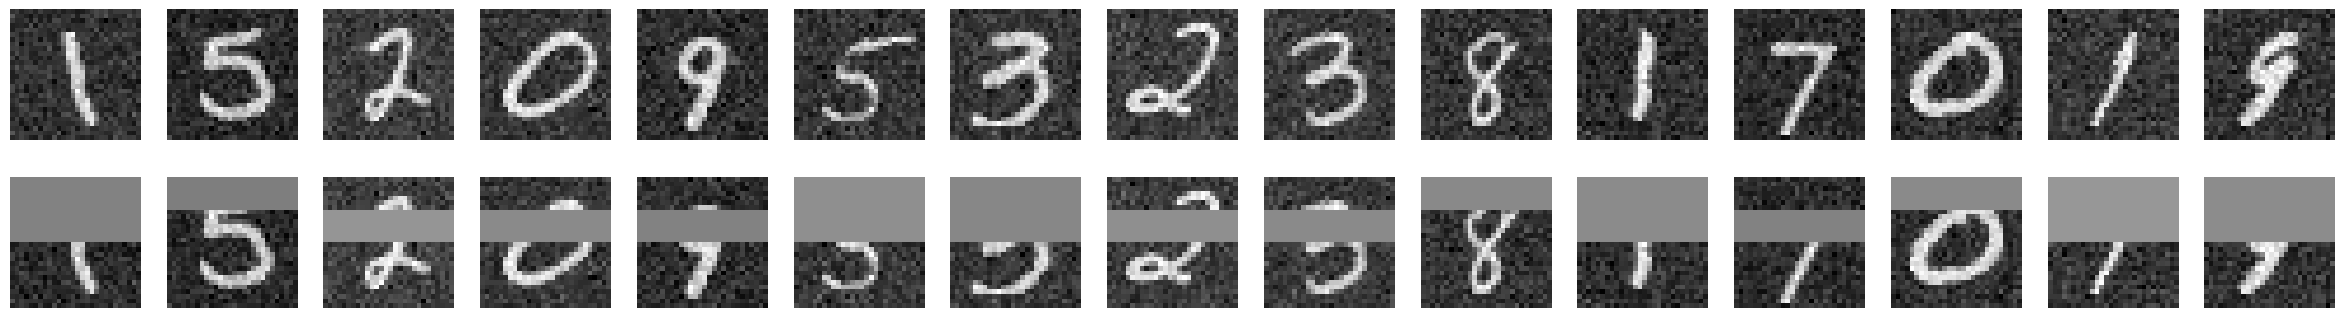

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# %%
n = bias.shape[0]
indices = np.random.choice(n, 15, replace=False)
plt.figure(figsize=(30, 4))
for i, idx in enumerate(indices):
    orig = bias[idx].reshape(28, 28)
    masked_bias = data_obs_bias[idx].copy()
    masked_bias[mask_bias[idx] == 0] = 0.5  # Use grey (0.5) for masked pixels
    plt.subplot(2, 15, i + 1)
    plt.imshow(orig, cmap='gray')
    plt.axis('off')
    if i == 0:
        plt.ylabel('Original')
    plt.subplot(2, 15, i + 16)
    plt.imshow(masked_bias.reshape(28, 28), cmap='gray')
    plt.axis('off')
    if i == 0:
        plt.ylabel('Masked')
plt.show()


 # Preprocessing

In [6]:
xfull = data_obs_bias.copy()
n, p = xfull.shape
xobs_zero = np.nan_to_num(xfull, 0)
mask_bool = mask_bias.copy()


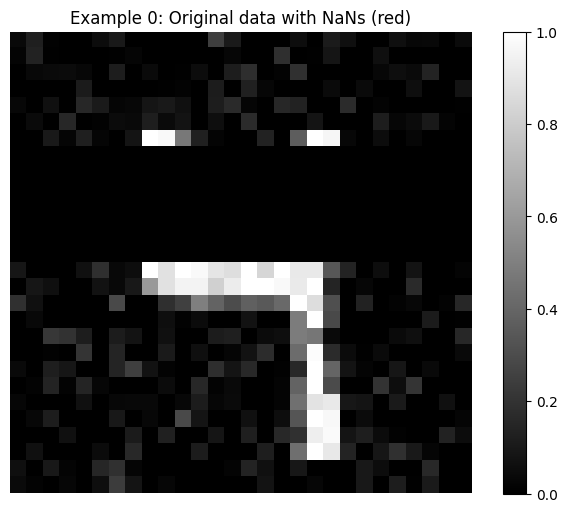

In [7]:
# Plot an example of xfull with NaNs colored red
plt.figure(figsize=(8, 6))
example_idx = 0
example_data = xfull[example_idx].reshape(28, 28)

# Create a custom colormap where NaNs are red
import matplotlib.colors as colors
cmap = plt.cm.gray.copy()
cmap.set_bad(color='red')

plt.imshow(example_data, cmap=cmap, vmin=0, vmax=1)
plt.title(f'Example {example_idx}: Original data with NaNs (red)')
plt.colorbar()
plt.axis('off')
plt.show()


 # Hyperparameters

In [8]:
h = 256
d = 1
K = 20


 # Model building

In [9]:
# class UNet(nn.Module):
#     def __init__(self, c_in=3, c_out=3, device="cuda"):
#         super().__init__()
#         self.device = device
#         self.inc = DoubleConv(c_in, 64)
#         self.down1 = Down(64, 128)
#         self.sa1 = SelfAttention(128, 32)
#         self.down2 = Down(128, 256)
#         self.sa2 = SelfAttention(256, 16)
#         self.down3 = Down(256, 256)
#         self.sa3 = SelfAttention(256, 8)

#         self.bot1 = DoubleConv(256, 512)
#         self.bot2 = DoubleConv(512, 512)
#         self.bot3 = DoubleConv(512, 256)

#         self.up1 = Up(512, 128)
#         self.sa4 = SelfAttention(128, 16)
#         self.up2 = Up(256, 64)
#         self.sa5 = SelfAttention(64, 32)
#         self.up3 = Up(128, 64)
#         self.sa6 = SelfAttention(64, 64)
#         self.outc = nn.Conv2d(64, c_out, kernel_size=1)

#     def forward(self, x):

#         x1 = self.inc(x)
#         x2 = self.down1(x1)
#         x2 = self.sa1(x2)
#         x3 = self.down2(x2)
#         x3 = self.sa2(x3)
#         x4 = self.down3(x3)
#         x4 = self.sa3(x4)

#         x4 = self.bot1(x4)
#         x4 = self.bot2(x4)
#         x4 = self.bot3(x4)

#         x = self.up1(x4, x3)
#         x = self.sa4(x)
#         x = self.up2(x, x2)
#         x = self.sa5(x)
#         x = self.up3(x, x1)
#         x = self.sa6(x)
#         output = self.outc(x)
#         return output

        
#         # Encoder components
#         self.encoder = nn.ModuleDict({
#             'inc': DoubleConv(c_in, 64),
#             'down1': Down(64, 128),
#             'sa1': SelfAttention(128, 32),
#             'down2': Down(128, 256),
#             'sa2': SelfAttention(256, 16),
#             'down3': Down(256, 256),
#             'sa3': SelfAttention(256, 8),
#             'bot1': DoubleConv(256, 512),
#             'bot2': DoubleConv(512, 512),
#             'bot3': DoubleConv(512, 256)
#         })
        
#         # Decoder components
#         self.decoder = nn.ModuleDict({
#             'up1': Up(512, 128),
#             'sa4': SelfAttention(128, 16),
#             'up2': Up(256, 64),
#             'sa5': SelfAttention(64, 32),
#             'up3': Up(128, 64),
#             'sa6': SelfAttention(64, 64),
#             'outc': nn.Conv2d(64, c_out, kernel_size=1)
#         })

#     def forward(self, x):

#         x1 = self.encoder['inc'](x)
#         x2 = self.encoder['down1'](x1)
#         x2 = self.encoder['sa1'](x2)
#         x3 = self.encoder['down2'](x2)
#         x3 = self.encoder['sa2'](x3)
#         x4 = self.encoder['down3'](x3)
#         x4 = self.encoder['sa3'](x4)

#         x4 = self.encoder['bot1'](x4)
#         x4 = self.encoder['bot2'](x4)
#         x4 = self.encoder['bot3'](x4)

#         x = self.decoder['up1'](x4, x3)
#         x = self.decoder['sa4'](x)
#         x = self.decoder['up2'](x, x2)
#         x = self.decoder['sa5'](x)
#         x = self.decoder['up3'](x, x1)
#         x = self.decoder['sa6'](x)
#         output = self.decoder['outc'](x)
#         return output


In [10]:
device = "cpu"
p_z = td.Independent(td.Normal(torch.zeros(d).to(device), torch.ones(d).to(device)), 1)

decoder = nn.Sequential(
    nn.Linear(d, h),
    nn.ReLU(),
    nn.Linear(h, h),
    nn.ReLU(),
    nn.Linear(h, 3 * p),
)

encoder = nn.Sequential(
    nn.Linear(p, h),
    nn.ReLU(),
    nn.Linear(h, h),
    nn.ReLU(),
    nn.Linear(h, 2 * d),
)

encoder.to(device)
decoder.to(device)


Sequential(
  (0): Linear(in_features=1, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=256, bias=True)
  (3): ReLU()
  (4): Linear(in_features=256, out_features=2352, bias=True)
)

 # MIWAE loss

In [11]:
def miwae_loss(iota_x, mask):
    batch = iota_x.shape[0]
    out = encoder(iota_x)
    q = td.Independent(td.Normal(out[..., :d], torch.nn.Softplus()(out[..., d:])), 1)
    z = q.rsample([K]).reshape([K * batch, d])
    dec = decoder(z)
    mu, scale, df = dec[:, :p], torch.nn.Softplus()(dec[:, p:2*p]) + 1e-3, torch.nn.Softplus()(dec[:, 2*p:]) + 3
    scale = torch.full_like(scale, 0.1)  # Ensure scale is not too small

    data_flat = iota_x.repeat(K, 1).reshape(-1, 1)
    mask_flat = mask.repeat(K, 1)
    # log_px = td.StudentT(df=df.reshape(-1,1), loc=mu.reshape(-1,1), scale=scale.reshape(-1,1)).log_prob(data_flat)
    log_px = td.Normal(loc=mu.reshape(-1, 1), scale=scale.reshape(-1, 1)).log_prob(data_flat)
    log_px = log_px.reshape(K * batch, p)
    # plt.imshow(mask_flat.reshape(K, batch, 28,28)[0][0].cpu().numpy(), cmap='gray')
    # plt.show()
    log_px_obs = (log_px * mask_flat).reshape(K, batch, p).sum(-1)
    log_pz = p_z.log_prob(z.reshape(K, batch, d))
    log_q = q.log_prob(z.reshape(K, batch, d))
    bound = torch.logsumexp(log_px_obs + log_pz - log_q, 0) - torch.log(torch.tensor(K, dtype=torch.float, device=iota_x.device))
    return -bound.mean()


In [12]:
optimizer = optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=1e-3)


 # Single imputation

In [13]:
def miwae_impute(iota_x, mask, L, device):
    batch = iota_x.shape[0]
    out = encoder(iota_x)
    q = td.Independent(td.Normal(out[..., :d], torch.nn.Softplus()(out[..., d:])), 1)
    z = q.rsample([L]).reshape([L * batch, d])
    dec = decoder(z)
    mu, scale, df = dec[:, :p], torch.nn.Softplus()(dec[:, p:2*p]) + 1e-3, torch.nn.Softplus()(dec[:, 2*p:]) + 3
    scale = torch.full_like(scale, 0.1)  # Ensure scale is not too small
    # scale = 0.01
    # log_px = td.StudentT(df=df.reshape(-1,1), loc=mu.reshape(-1,1), scale=scale.reshape(-1,1)).log_prob(iota_x.repeat(L,1).reshape(-1,1)).reshape(L, batch, p)
    log_px = td.Normal(loc=mu.reshape(-1, 1), scale=scale.reshape(-1, 1)).log_prob(iota_x.repeat(L, 1).reshape(-1, 1)).reshape(L, batch, p)

    log_pz = p_z.log_prob(z.reshape(L, batch, d))
    log_q = q.log_prob(z.reshape(L, batch, d))
    w = torch.nn.functional.softmax(log_px.sum(-1) + log_pz - log_q, 0)
    x_samples = td.Independent(td.StudentT(df=df.reshape(-1,1), loc=mu.reshape(-1,1), scale=scale.reshape(-1,1)),1).sample().reshape(L, batch, p)
    return torch.einsum('lb,lbp->bp', w, x_samples)


 # Training

Epoch 0 bound -2541.19921875
Imputation MSE 0.14538716722028994


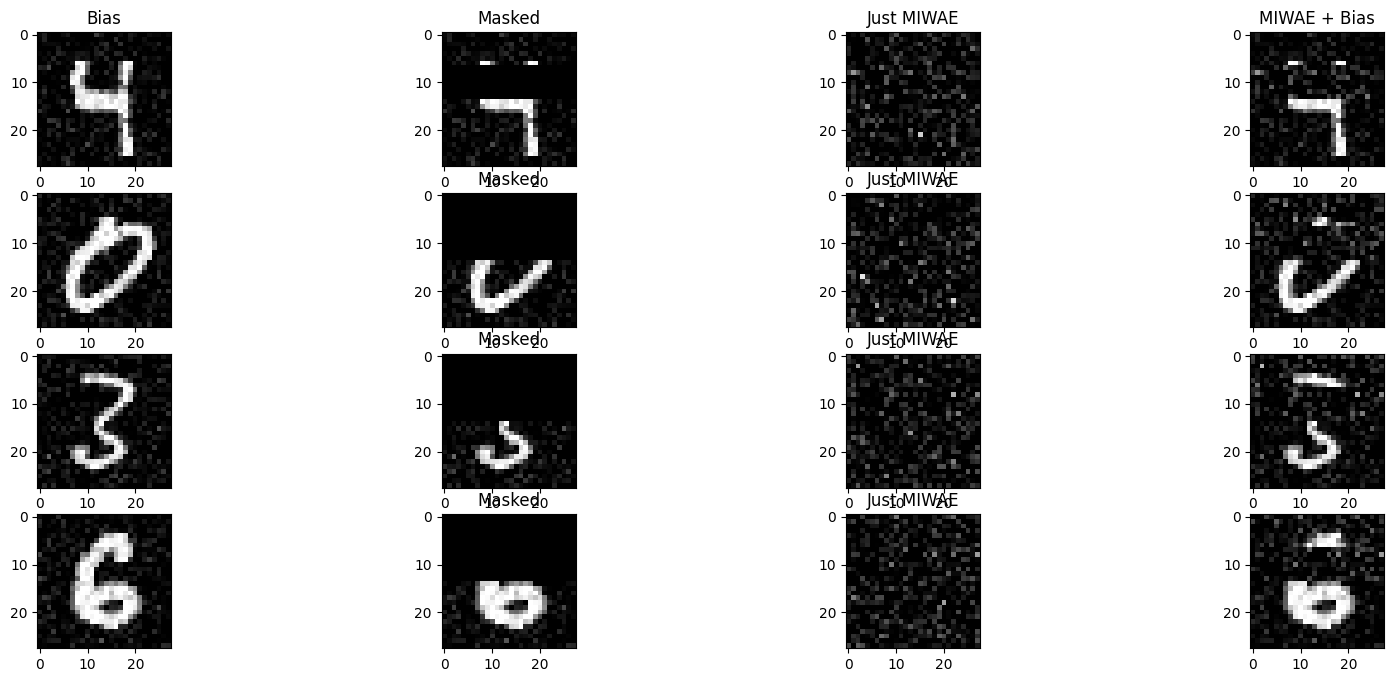

Epoch 5 bound -742.3544921875
Imputation MSE 0.09334428273864086


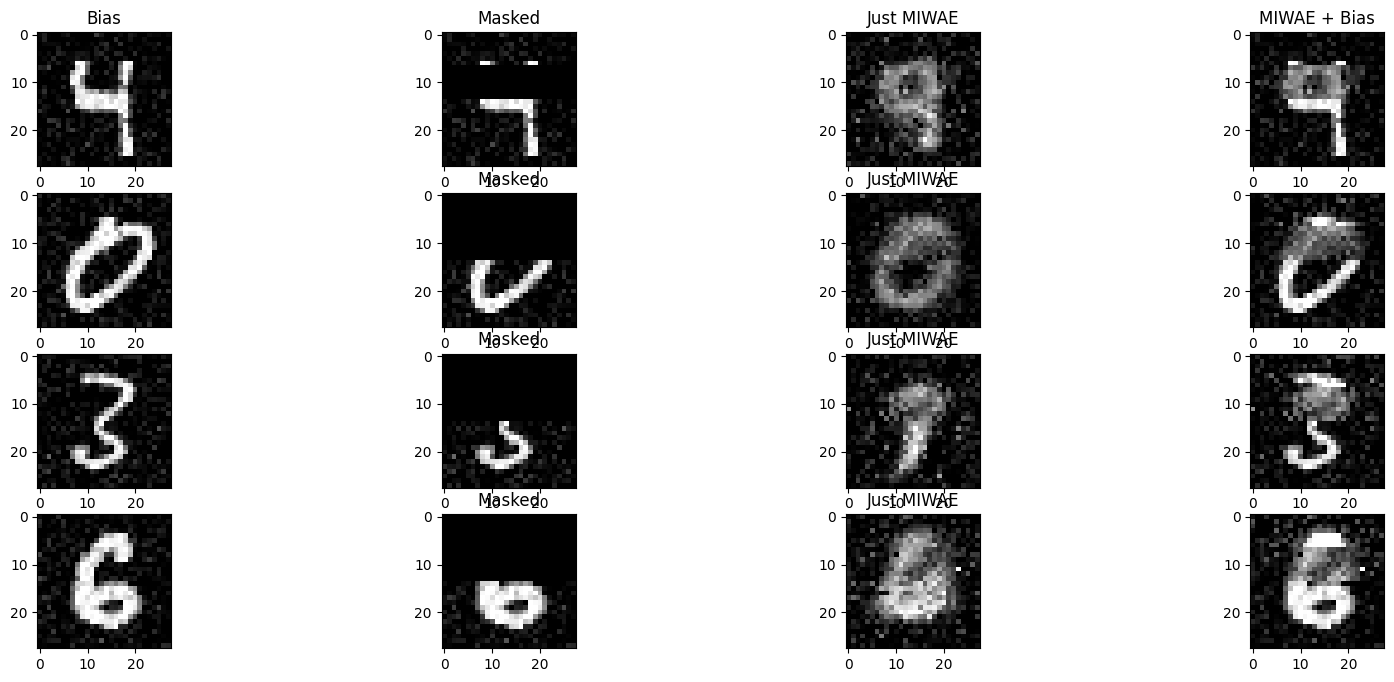

Epoch 10 bound -661.5115356445312
Imputation MSE 0.09156219918274834


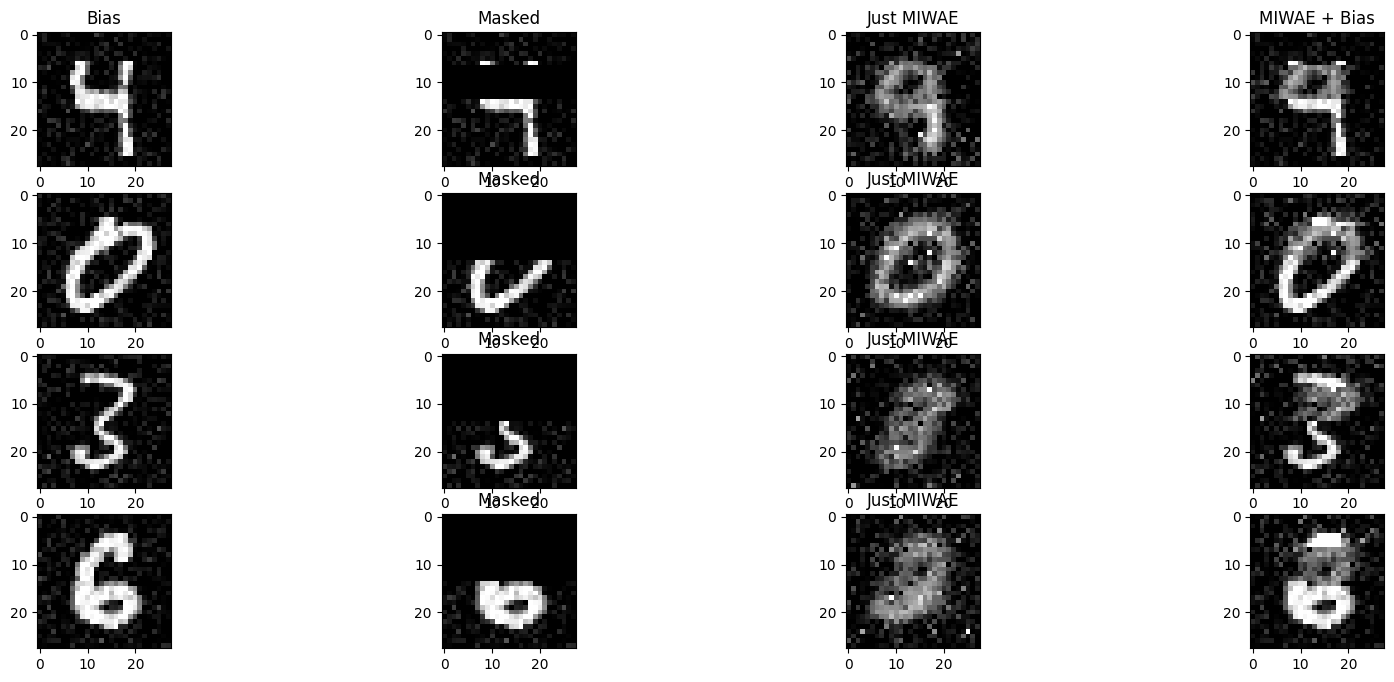

Epoch 15 bound -619.7974243164062
Imputation MSE 0.09122394959221065


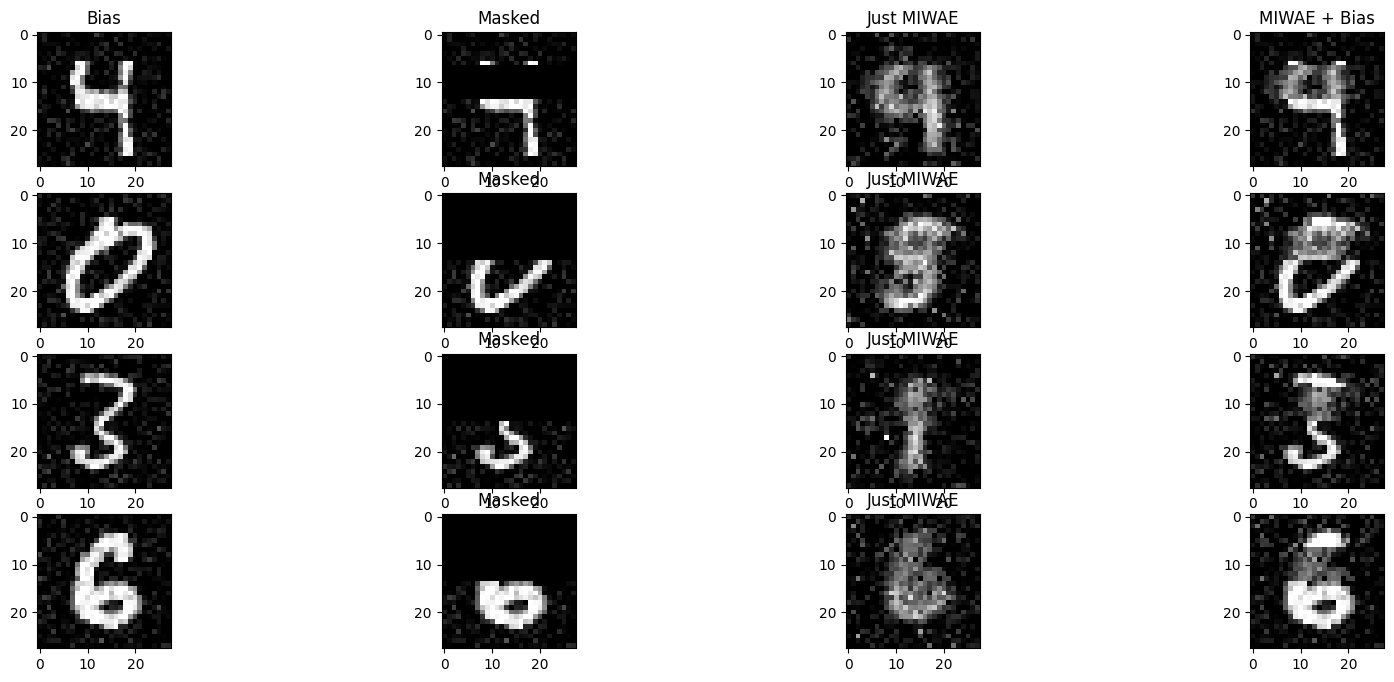

Epoch 20 bound -603.844482421875
Imputation MSE 0.09074950009138995


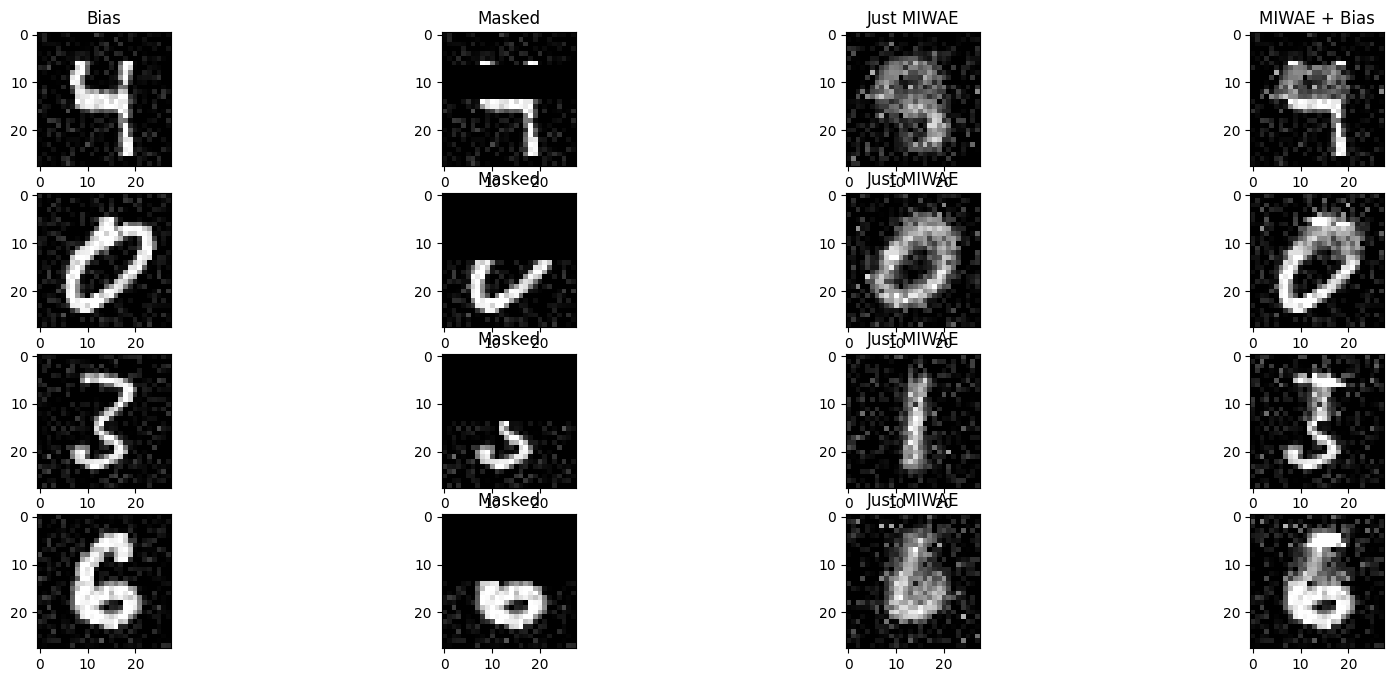

In [ ]:
xhat = xobs_zero.copy()
mask_t = mask_bool.astype(float)
bs = 64
epochs = 2000

for ep in range(0, epochs):
    if ep % 5 == 0:
        with torch.no_grad():
            total_bound = -miwae_loss(torch.tensor(xhat, dtype=torch.float).to(device), torch.tensor(mask_t, dtype=torch.float).to(device))
            print(f'Epoch {ep} bound {total_bound.item()}')
            xhat_tensor = miwae_impute(torch.tensor(xhat, dtype=torch.float).to(device), torch.tensor(mask_t, dtype=torch.float).to(device), 10, device).cpu().numpy()
            print(f'Imputation MSE {np.mean((xhat_tensor - bias)[mask_bool == 0]**2)}')
            fig, axs = plt.subplots(4, 4, figsize=(20, 8))
            axs[0,0].set_title('Bias')
            axs[0,1].set_title('Masked')
            axs[0,2].set_title('Just MIWAE')
            axs[0,3].set_title('MIWAE + Bias')
            for i in range(4):                
                axs[i,0].imshow(bias[i].reshape(28, 28), cmap='gray', vmin=0, vmax=1)
                axs[i,1].imshow(xobs_zero[i].reshape(28, 28), cmap='gray', vmin=0, vmax=1)
                axs[i,1].set_title('Masked')
                axs[i,2].imshow(xhat_tensor[i].reshape(28, 28), cmap='gray', vmin=0, vmax=1)
                axs[i,2].set_title('Just MIWAE')
                axs[i,3].imshow(xhat_tensor[i].reshape(28, 28) * (1-mask_bool[i]).reshape(28, 28) + bias[i].reshape(28, 28) * mask_bool[0].reshape(28, 28)
                            , cmap='gray', vmin=0, vmax=1)
            plt.show()
    idx = np.random.permutation(n)
    for i in range(0, n, bs):
        batch_id = idx[i:i+bs]
        b_x = torch.tensor(xhat[batch_id], dtype=torch.float).to(device)
        b_m = torch.tensor(mask_t[batch_id], dtype=torch.float).to(device)
        optimizer.zero_grad()
        loss = miwae_loss(b_x, b_m)
        loss.backward()
        optimizer.step()
    

